# 1. Set constants

In [1]:
PICTURE_SIZE = 608
FORCE_CPU = False

# 2. Import libraries

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import matplotlib.pyplot as plt
import time
from random import uniform
from sklearn.preprocessing import StandardScaler
import json
import os

# 3. Define classes and functions

## 3.1. PollenDataset

In [3]:
class PollenDataset(Dataset):
    def __init__(self, data_file, labels_file, main_class=None):
        # load the csv files
        df = pd.read_csv(data_file)
        labels_csv = pd.read_csv(labels_file, header=None, usecols=[0,1])
        
        # extract the "image" columns' names
        cols = []
        for i in range(df.shape[1]-2):
            cols.append('Feature %d'%(i+1))
        #end for i
        
        # transform "image" data
        sc = StandardScaler()
        X = sc.fit_transform(df[cols].values)
        
        # get labels
        self.labels = {}
        for row in labels_csv.values:
            class_name, label = row[0], row[1]
            if main_class != None:
                if label == main_class:
                    label = 0
                else:
                    label = 1
                #end if
            #end if
            self.labels[class_name] = label
        #end for
        
        # change labels to numbers
        y_ = df['Pollen Type'].values
        y = [self.labels[label] for label in y_]
        
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y)
    #end def

    def __len__(self):
        return len(self.y)
    #end def

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    #end def
#end class definition

## 3.2. Functions for loading data

### 3.2.1. splitData

In [4]:
def splitData(dataset, test_percent=0.15, valid_percent=0.15):
    # get total number of data
    total_items = len(dataset)
    
    # calculate the number of items in train/test/validation data
    no_of_test = int(total_items * test_percent)
    no_of_valid = int(total_items * valid_percent)
    no_of_train = total_items - (no_of_valid + no_of_test)
    
    # split the dataset
    train_data, test_data, valid_data = random_split(dataset, [no_of_train, no_of_test, no_of_valid])
    
    return (train_data, test_data, valid_data)
#end def

### 3.2.2. createDataLoaders

In [5]:
# convert dataset to DataLoaders
def createDataLoaders(train_data, test_data, valid_data, batch_size, shuffle=(True, False, False)):
    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle[0], num_workers=0)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle[1], num_workers=0)
    validloader = DataLoader(valid_data, batch_size=batch_size, shuffle=shuffle[2], num_workers=0)
    
    return (trainloader, testloader, validloader)
#end def

## 3.3. getClassWeights

In [6]:
def getClassWeights(dataset, no_of_classes, power=1, force_cpu=False):
    # we will count the members of each class
    elems_per_class = [0] * no_of_classes

    # iterate through data labels and count them
    for data in dataset:
        labels = data[1]
        elems_per_class[labels] += 1
    #end for data

    # each class will have a weight disproportionate to their size
    M = max(elems_per_class)
    weights = [(M/no_of_elems)**power for no_of_elems in elems_per_class]
    
    if force_cpu:
        DEVICE = torch.device("cpu")
    else:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #end if
    
    class_weights = torch.FloatTensor(weights).to(DEVICE)
    return class_weights
#end def

## 3.4. PollenClassifier

In [7]:
class PollenClassifier():
    def __init__(self, model, force_cpu=False):
        self.model = model
        
        # default: use GPU if possible
        if force_cpu:
            self.device = torch.device("cpu")
        else:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #end if
        
        self.model.to(self.device)
    #end def
    
    def train(self, trainloader, validloader, loss_fn, optimizer, epochs=10, print_all=False, autosave=True, save_path=None):
        # initialize training history
        self.history = {}
        self.history['train_loss'] = []
        self.history['valid_loss'] = []
        self.history['train_acc'] = []
        self.history['valid_acc'] = []
        
        # move loss function to CPU or GPU
        loss_fn.to(self.device)
        
        # print some information about the training
        print('Model=%s, opt=%s, lr=%f, reg=%f, epochs=%d, device=%s' % (
            type(self.model).__name__,
            type(optimizer).__name__,
            optimizer.param_groups[0]['lr'],
            optimizer.param_groups[0]['weight_decay'],
            epochs,
            self.device
        ))
        
        # initialize autosave folder
        if autosave:
            if save_path != None and (not os.path.exists(save_path)):
                os.makedirs(save_path)
                self.autosave_path = save_path
            else:
                # folder will be named after current date and time
                current_time = time.strftime("%y%m%d_%H%M%S", time.localtime())
                folder_name = 'AUTOSAVE_' + current_time
                if save_path != None:
                    print('The folder ' + save_path + ' already exists.')
                #end if
                self.autosave_path = folder_name
                print('Saving to ' + folder_name + '...')
                
                # create the folder (if it doesn't exist)
                if not os.path.exists(folder_name):
                    os.makedirs(folder_name)
                #end if
            #end if
            
            # collect the info about the model
            data_to_save = {
                'model': type(self.model).__name__,
                'optimizer': type(optimizer).__name__,
                'learning_rate': optimizer.param_groups[0]['lr'],
                'weight_decay': optimizer.param_groups[0]['weight_decay'],
                'no_of_epochs': epochs,
                'device': self.device.type
            }
            
            # save the info
            with open(self.autosave_path + '/info.json', 'w') as file:
                json.dump(data_to_save, file, indent=4)
            #end with open
        #end if
        
        # True prints all data; False prints only the number of epochs finished
        if print_all:
            current_time = time.strftime("%H:%M:%S", time.localtime())
            print('\nTraining started at ' + current_time)
            print('=' * 110)
        else:
            print('   [', end='')
        #end if
        
        # this will act as our stopwatch
        start_time_sec = time.time()
        
        # now the training actually begins
        for epoch in range(1, epochs+1):
            # this lets us know that the epoch actually started
            if print_all: print('Epoch %3d started' % epoch, end='')
            
            ####################### Training #######################
            # initialize values
            train_loss = 0.0
            num_train_correct = 0
            num_train_total = 0
            
            # iterate through train data
            for data in trainloader:
                # get the data
                inputs = data[0].to(self.device)
                labels = data[1].to(self.device)
                
                # set gradients to zero
                optimizer.zero_grad()
                
                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                
                # accumulate loss and predictions
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                num_train_correct += predicted.eq(labels).sum().item()
                num_train_total += labels.size(0)
            #end for data
            
            # calculate train loss and add it to the history
            train_loss = train_loss / len(trainloader)
            self.history['train_loss'].append(train_loss)
            
            # calculate train accuracy and add it to the history
            train_acc = 100. * num_train_correct / num_train_total
            self.history['train_acc'].append(train_acc)
            
            ####################### Validation #######################
            # initialize values
            valid_loss = 0.0
            num_valid_correct = 0
            num_valid_total = 0
            
            # iterate through validation data (without calculating gradients)
            with torch.no_grad():
                for data in validloader:
                    # get the data
                    inputs = data[0].to(self.device)
                    labels = data[1].to(self.device)

                    # forward pass
                    outputs = self.model(inputs)
                    loss = loss_fn(outputs, labels)

                    # accumulate loss and predictions
                    valid_loss += loss.item()
                    _, predicted = outputs.max(1)
                    num_valid_correct += predicted.eq(labels).sum().item()
                    num_valid_total += labels.size(0)
                #end for data
            #end with torch.no_grad()
            
            # calculate valdation loss and add it to the history
            valid_loss = valid_loss / len(validloader)
            self.history['valid_loss'].append(valid_loss)
            
            # calculate valdation accuracy and add it to the history
            valid_acc = 100. * num_valid_correct / num_valid_total
            self.history['valid_acc'].append(valid_acc)
            
            ####################### End the epoch #######################
            # True will print the time elapsed, losses and accuracies
            # False will only let us know the epoch ended successfully
            if print_all:
                current_time_sec = time.time()
                time_so_far_sec = current_time_sec - start_time_sec
                print('   DONE')
                print('current_time: %5.2f sec' % (time_so_far_sec), end='')
                print(' | train_loss: %.3f | train_acc: %2.3f %%' % (train_loss, train_acc), end='')
                print(' | valid_loss: %.3f | valid_acc: %2.3f %%' % (valid_loss, valid_acc))
                print('-' * 110)
            else:
                print(epoch % 10, end='')
            #end if
            
            # autosave
            if autosave: self.__autosave(epoch)
        #end for epoch
        
        ################ Finalize training ################
        # print total time
        end_time_sec = time.time()
        total_time_sec = end_time_sec - start_time_sec
        if print_all:
            print()
        else:
            print(']')
        #end if
        print('Time total:  %5.2f sec' % (total_time_sec))
        
        # if True, print the exact time when the training ended
        # if False, print only the final validation accuracy
        if print_all:
            t = time.localtime()
            current_time = time.strftime("%H:%M:%S", t)
            print('=' * 110)
            print('Training ended at ' + current_time)
        else:
            print(' valid_acc: %2.3f %%' % (valid_acc))
        #end if
    #end def
    
    def test(self, testloader):
        # initialize values
        total, correct = 0, 0
        
        # iterate through test data (without calculating gradients)
        with torch.no_grad():
            for data in testloader:
                # get the data
                inputs = data[0].to(self.device)
                labels = data[1].to(self.device)

                # calculate outputs by running images through the network
                outputs = self.model(inputs)

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            #end for data
        #end with torch.no_grad()
        
        return 100. * correct / total
    #end def
    
    def testPerClass(self, testloader, classes):
        # initialize dictionaries
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}

        # iterate through test data (without calculating gradients)
        with torch.no_grad():
            for data in testloader:
                # get the data
                inputs = data[0].to(self.device)
                labels = data[1].to(self.device)
                
                # calculate outputs by running images through the network
                outputs = self.model(inputs)
                
                # the class with the highest energy is what we choose as prediction
                _, predictions = torch.max(outputs, 1)

                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[classes[label.item()]] += 1
                    #end if
                    total_pred[classes[label.item()]] += 1
                #end for label, prediction
            #end for data
        #end with torch.no_grad()

        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100. * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:s} is: {:.2f} %".format(classname, accuracy))
        #end for classname, correct_count
    #end def
    
    def save(self, path):
        torch.save(self.model.state_dict(), path)
    #end def
    
    def load(self, path):
        self.model.load_state_dict(torch.load(path))
    #end def
    
    def __autosave(self, epoch):
        path = self.autosave_path + '/Epoch_' + str(epoch) + '.pth' 
        torch.save(self.model.state_dict(), path)
    #end def
    
    def display_acc(self):
        xx = range(1, len(self.history['train_acc'])+1)
        plt.plot(xx, self.history['train_acc'], '-o')
        plt.plot(xx, self.history['valid_acc'], '-o')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['Train', 'Valid'])
        plt.title('Train vs Valid accuracy')
        plt.show()
    #end def
    
    def display_loss(self):
        xx = range(1, len(self.history['train_loss'])+1)
        plt.plot(xx, self.history['train_loss'], '-o')
        plt.plot(xx, self.history['valid_loss'], '-o')
        plt.xlabel('epoch')
        plt.ylabel('losses')
        plt.legend(['Train', 'Valid'])
        plt.title('Train vs Valid losses')
        plt.show()
    #end def
#end class definition

## 3.5. CNN architectures

### 3.5.1. CNN_Odin

In [8]:
class CNN_Odin(nn.Module):
    def __init__(self, no_of_classes, picture_size):
        super().__init__()
        
        size_in = picture_size
        filters_in, filters_out = 1, 96
        kernel_size, padding, stride = 5, 2, 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 256
        kernel_size, padding, stride = 5, 2, 1
        self.conv2 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 384
        kernel_size, padding, stride = 5, 2, 1
        self.conv3 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 384
        kernel_size, padding, stride = 3, 1, 1
        self.conv4 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 256
        kernel_size, padding, stride = 3, 1, 1
        self.conv5 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        
        size_in = filters_out * size_in
        size_out = 4096
        self.fc1 = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.ReLU()
        )
        
        size_in, size_out = size_out, 2048
        self.fc2 = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.ReLU()
        )
        
        size_in, size_out = size_out, no_of_classes
        self.fc_final = nn.Linear(size_in, size_out)
    #end def
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc_final(x)
        return x
    #end def
#end class definition

### 3.5.2. CNN_Odinson

In [9]:
class CNN_Odinson(nn.Module):
    def __init__(self, no_of_classes, picture_size):
        super().__init__()
        
        size_in = picture_size
        filters_in, filters_out = 1, 96
        kernel_size, padding, stride = 5, 2, 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 256
        kernel_size, padding, stride = 5, 2, 1
        self.conv2 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 384
        kernel_size, padding, stride = 5, 2, 1
        self.conv3 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 384
        kernel_size, padding, stride = 3, 1, 1
        self.conv4 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 256
        kernel_size, padding, stride = 3, 1, 1
        self.conv5 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        
        size_in = filters_out * size_in
        size_out = 2048
        self.fc1 = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.ReLU()
        )
        
        size_in, size_out = size_out, no_of_classes
        self.fc_final = nn.Linear(size_in, size_out)
    #end def
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc_final(x)
        return x
    #end def
#end class definition

### 3.5.3. CNN_Ymir

In [10]:
class CNN_Ymir(nn.Module):
    def __init__(self, no_of_classes, picture_size):
        super().__init__()
        
        size_in = picture_size
        filters_in, filters_out = 1, 128
        kernel_size, padding, stride = 5, 2, 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 256
        kernel_size, padding, stride = 5, 2, 1
        self.conv2 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 512
        kernel_size, padding, stride = 5, 2, 1
        self.conv3 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 512
        kernel_size, padding, stride = 3, 1, 1
        self.conv4 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 256
        kernel_size, padding, stride = 3, 1, 1
        self.conv5 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        filters_in, filters_out = filters_out, 128
        kernel_size, padding, stride = 3, 1, 1
        self.conv6 = nn.Sequential(
            nn.Conv1d(filters_in, filters_out, kernel_size, padding=padding, stride=stride),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        size_in = ((size_in - kernel_size + 2*padding) // stride + 1) // 2
        
        size_in = filters_out * size_in
        size_out = 2048
        self.fc1 = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.ReLU()
        )
        
        size_in, size_out = size_out, 2048
        self.fc2 = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.ReLU()
        )
        
        size_in, size_out = size_out, no_of_classes
        self.fc_final = nn.Linear(size_in, size_out)
    #end def
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc_final(x)
        return x
    #end def
#end class definition

# 4. First try

## 4.1. Define classes

In [11]:
classes = (
    'Alnus Glutin',
    'Ambrosia Artemisifolia',
    'Artemisia Vulgaris',
    'Betula Pendula',
    'Cedrus',
    'Corylus Avelana',
    'Quercus',
    'Urtica Diocia'
)

no_of_classes = len(classes)

## 4.2. Load data and calculate weights

In [12]:
dataset = PollenDataset(data_file='./data.csv', labels_file='./labels.csv')

(train_data, test_data, valid_data) = splitData(
    dataset,
    test_percent=0.15,
    valid_percent=0.15
)

(trainloader, testloader, validloader) = createDataLoaders(
    train_data, test_data, valid_data, batch_size=4
)

class_weights = getClassWeights(train_data, no_of_classes)

## 4.3. Define the network and train it

<b>Note: </b> If using CUDA, a warning may pop up the first time you run this code.

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0
Saving to AUTOSAVE_210912_115949...

Training started at 11:59:49
Epoch   1 started   DONE
current_time: 117.22 sec | train_loss: 1.789 | train_acc: 58.876 % | valid_loss: 1.675 | valid_acc: 58.640 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 234.19 sec | train_loss: 1.527 | train_acc: 59.598 % | valid_loss: 1.458 | valid_acc: 59.524 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 351.16 sec | train_loss: 1.370 | train_acc: 62.258 % | valid_loss: 1.397 | valid_acc: 57.285 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 468.38 sec | train_loss: 1.267 | train_acc: 64.485 % | valid_loss: 1.343 | valid_a

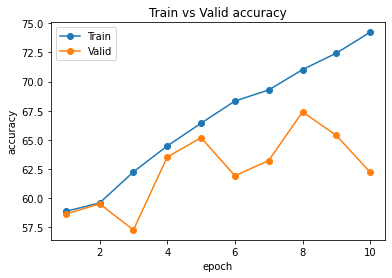

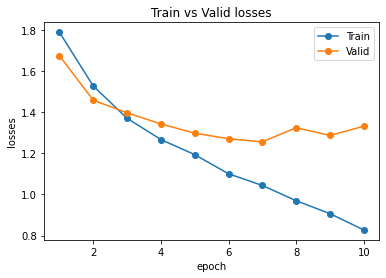

In [14]:
no_of_epochs = 10
lr = 1e-4
reg = 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True)
classifier.display_acc()
classifier.display_loss()

## 4.4. Test the network

In [15]:
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

Test accuracy:  64.612 %

Accuracy for class Alnus Glutin is: 45.00 %
Accuracy for class Ambrosia Artemisifolia is: 56.34 %
Accuracy for class Artemisia Vulgaris is: 57.55 %
Accuracy for class Betula Pendula is: 23.96 %
Accuracy for class Cedrus is: 73.95 %
Accuracy for class Corylus Avelana is: 47.39 %
Accuracy for class Quercus is: 79.56 %
Accuracy for class Urtica Diocia is: 41.99 %


## 4.5. Let's try rewinding to an earlier epoch

In [16]:
classifier.load('./AUTOSAVE_210912_115949/Epoch_8.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

print('-' * 110)

classifier.load('./AUTOSAVE_210912_115949/Epoch_9.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

Test accuracy:  68.897 %

Accuracy for class Alnus Glutin is: 19.17 %
Accuracy for class Ambrosia Artemisifolia is: 53.52 %
Accuracy for class Artemisia Vulgaris is: 54.70 %
Accuracy for class Betula Pendula is: 60.37 %
Accuracy for class Cedrus is: 82.73 %
Accuracy for class Corylus Avelana is: 10.43 %
Accuracy for class Quercus is: 84.28 %
Accuracy for class Urtica Diocia is: 44.59 %
--------------------------------------------------------------------------------------------------------------
Test accuracy:  66.962 %

Accuracy for class Alnus Glutin is: 16.67 %
Accuracy for class Ambrosia Artemisifolia is: 52.11 %
Accuracy for class Artemisia Vulgaris is: 58.97 %
Accuracy for class Betula Pendula is: 47.47 %
Accuracy for class Cedrus is: 76.62 %
Accuracy for class Corylus Avelana is: 36.97 %
Accuracy for class Quercus is: 85.53 %
Accuracy for class Urtica Diocia is: 49.78 %


## 4.6. We can try different architectures

### 4.6.1 CNN_Odinson

Model=CNN_Odinson, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 12:22:15
Epoch   1 started   DONE
current_time: 56.08 sec | train_loss: 1.780 | train_acc: 58.994 % | valid_loss: 1.633 | valid_acc: 61.847 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 112.24 sec | train_loss: 1.503 | train_acc: 60.955 % | valid_loss: 1.439 | valid_acc: 61.653 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 168.10 sec | train_loss: 1.334 | train_acc: 63.674 % | valid_loss: 1.401 | valid_acc: 60.575 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 224.31 sec | train_loss: 1.226 | train_acc: 65.753 % | valid_loss: 1.298 | valid_acc: 62.179 %
---------------------

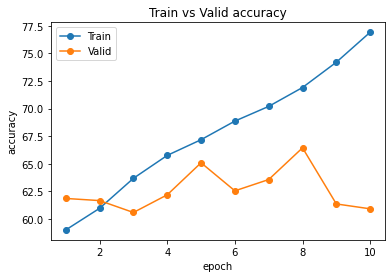

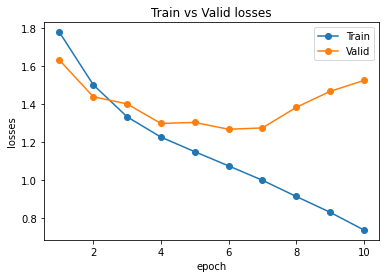

Test accuracy:  62.040 %

Accuracy for class Alnus Glutin is: 53.33 %
Accuracy for class Ambrosia Artemisifolia is: 46.48 %
Accuracy for class Artemisia Vulgaris is: 62.39 %
Accuracy for class Betula Pendula is: 40.55 %
Accuracy for class Cedrus is: 68.72 %
Accuracy for class Corylus Avelana is: 25.59 %
Accuracy for class Quercus is: 79.56 %
Accuracy for class Urtica Diocia is: 46.32 %


In [17]:
no_of_epochs = 10
lr = 1e-4
reg = 1e-4

model = CNN_Odinson(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True, save_path='./Odinson_first_try')
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

#### Let's try rewinding

In [18]:
classifier.load('./Odinson_first_try/Epoch_5.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

print('-' * 110)

classifier.load('./Odinson_first_try/Epoch_8.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

Test accuracy:  66.105 %

Accuracy for class Alnus Glutin is: 43.33 %
Accuracy for class Ambrosia Artemisifolia is: 32.39 %
Accuracy for class Artemisia Vulgaris is: 56.13 %
Accuracy for class Betula Pendula is: 32.26 %
Accuracy for class Cedrus is: 79.87 %
Accuracy for class Corylus Avelana is: 15.64 %
Accuracy for class Quercus is: 87.11 %
Accuracy for class Urtica Diocia is: 41.99 %
--------------------------------------------------------------------------------------------------------------
Test accuracy:  68.482 %

Accuracy for class Alnus Glutin is: 35.00 %
Accuracy for class Ambrosia Artemisifolia is: 50.70 %
Accuracy for class Artemisia Vulgaris is: 56.13 %
Accuracy for class Betula Pendula is: 32.26 %
Accuracy for class Cedrus is: 82.04 %
Accuracy for class Corylus Avelana is: 26.54 %
Accuracy for class Quercus is: 85.22 %
Accuracy for class Urtica Diocia is: 45.89 %


### 4.6.2 CNN_Ymir

Model=CNN_Ymir, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 12:33:29
Epoch   1 started   DONE
current_time: 54.27 sec | train_loss: 1.821 | train_acc: 59.391 % | valid_loss: 1.717 | valid_acc: 62.787 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 108.24 sec | train_loss: 1.663 | train_acc: 60.896 % | valid_loss: 1.611 | valid_acc: 62.151 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 162.35 sec | train_loss: 1.558 | train_acc: 58.864 % | valid_loss: 1.568 | valid_acc: 61.819 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 216.54 sec | train_loss: 1.481 | train_acc: 59.284 % | valid_loss: 1.536 | valid_acc: 50.539 %
------------------------

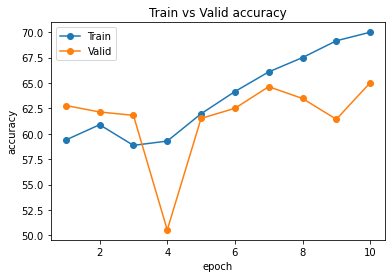

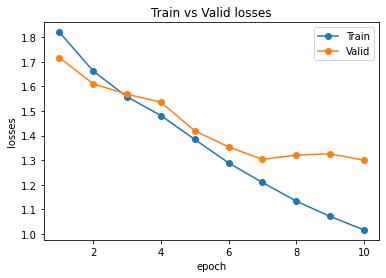

Test accuracy:  66.630 %

Accuracy for class Alnus Glutin is: 24.17 %
Accuracy for class Ambrosia Artemisifolia is: 47.89 %
Accuracy for class Artemisia Vulgaris is: 60.68 %
Accuracy for class Betula Pendula is: 51.15 %
Accuracy for class Cedrus is: 77.90 %
Accuracy for class Corylus Avelana is: 31.28 %
Accuracy for class Quercus is: 75.79 %
Accuracy for class Urtica Diocia is: 44.59 %


In [19]:
no_of_epochs = 10
lr = 1e-4
reg = 1e-4

model = CNN_Ymir(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True, save_path='./Ymir_first_try')
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

## 4.7. We can try different hyperparameters

### 4.7.1 CNN_Odin

Model=CNN_Odin, opt=Adam, lr=0.000200, reg=0.000100, epochs=15, device=cuda:0

Training started at 00:47:27
Epoch   1 started   DONE
current_time: 117.25 sec | train_loss: 1.827 | train_acc: 58.941 % | valid_loss: 1.708 | valid_acc: 61.460 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 235.19 sec | train_loss: 1.659 | train_acc: 60.913 % | valid_loss: 1.684 | valid_acc: 63.976 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 353.29 sec | train_loss: 1.574 | train_acc: 58.864 % | valid_loss: 1.535 | valid_acc: 59.663 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 470.51 sec | train_loss: 1.454 | train_acc: 59.699 % | valid_loss: 1.435 | valid_acc: 58.308 %
-----------------------

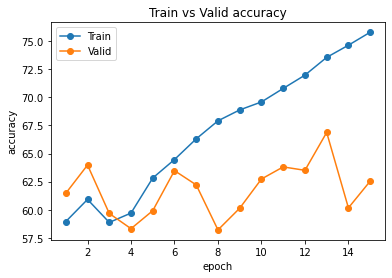

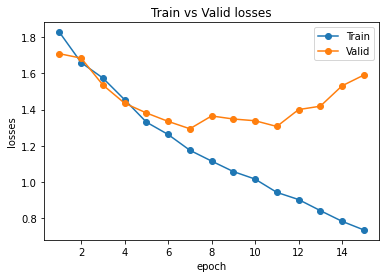

Test accuracy:  61.349 %

Accuracy for class Alnus Glutin is: 32.48 %
Accuracy for class Ambrosia Artemisifolia is: 40.97 %
Accuracy for class Artemisia Vulgaris is: 68.87 %
Accuracy for class Betula Pendula is: 23.66 %
Accuracy for class Cedrus is: 70.62 %
Accuracy for class Corylus Avelana is: 29.91 %
Accuracy for class Quercus is: 83.22 %
Accuracy for class Urtica Diocia is: 43.70 %


In [14]:
no_of_epochs = 15
lr = 2e-4
reg = 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True, save_path='./Odin_higher_lr')
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

### 4.7.2 CNN_Odinson

Model=CNN_Odinson, opt=Adam, lr=0.000050, reg=0.000100, epochs=15, device=cuda:0

Training started at 13:13:32
Epoch   1 started   DONE
current_time: 55.25 sec | train_loss: 1.769 | train_acc: 58.799 % | valid_loss: 1.659 | valid_acc: 60.437 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 110.71 sec | train_loss: 1.532 | train_acc: 60.576 % | valid_loss: 1.469 | valid_acc: 62.732 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 166.29 sec | train_loss: 1.352 | train_acc: 63.040 % | valid_loss: 1.438 | valid_acc: 63.008 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 221.81 sec | train_loss: 1.246 | train_acc: 66.013 % | valid_loss: 1.313 | valid_acc: 66.464 %
---------------------

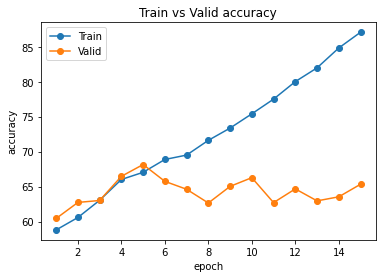

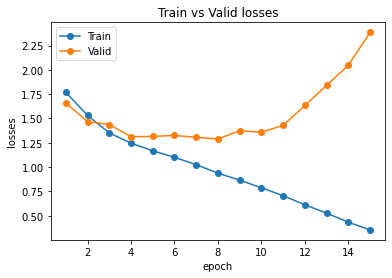

Test accuracy:  67.515 %

Accuracy for class Alnus Glutin is: 14.17 %
Accuracy for class Ambrosia Artemisifolia is: 47.89 %
Accuracy for class Artemisia Vulgaris is: 64.96 %
Accuracy for class Betula Pendula is: 32.26 %
Accuracy for class Cedrus is: 79.63 %
Accuracy for class Corylus Avelana is: 30.33 %
Accuracy for class Quercus is: 87.11 %
Accuracy for class Urtica Diocia is: 45.02 %


In [22]:
no_of_epochs = 15
lr = 5e-5
reg = 1e-4

model = CNN_Odinson(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True, save_path='./Odinson_lower_lr')
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

### 4.7.3 CNN_Ymir

Model=CNN_Ymir, opt=Adam, lr=0.000050, reg=0.000100, epochs=15, device=cuda:0

Training started at 13:27:48
Epoch   1 started   DONE
current_time: 53.99 sec | train_loss: 1.817 | train_acc: 59.077 % | valid_loss: 1.726 | valid_acc: 60.824 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 108.14 sec | train_loss: 1.633 | train_acc: 61.417 % | valid_loss: 1.609 | valid_acc: 60.409 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 162.30 sec | train_loss: 1.507 | train_acc: 59.136 % | valid_loss: 1.490 | valid_acc: 57.949 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 216.52 sec | train_loss: 1.379 | train_acc: 62.228 % | valid_loss: 1.431 | valid_acc: 59.829 %
------------------------

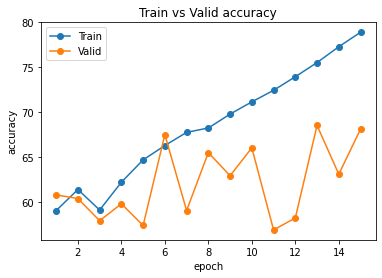

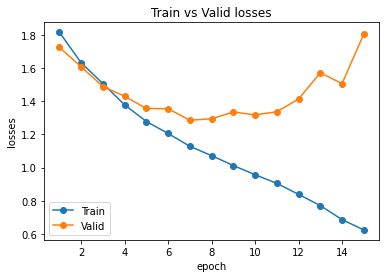

Test accuracy:  68.316 %

Accuracy for class Alnus Glutin is: 12.50 %
Accuracy for class Ambrosia Artemisifolia is: 31.69 %
Accuracy for class Artemisia Vulgaris is: 64.10 %
Accuracy for class Betula Pendula is: 41.01 %
Accuracy for class Cedrus is: 84.16 %
Accuracy for class Corylus Avelana is: 22.75 %
Accuracy for class Quercus is: 76.73 %
Accuracy for class Urtica Diocia is: 42.86 %


In [23]:
no_of_epochs = 15
lr = 5e-5
reg = 1e-4

model = CNN_Ymir(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True, save_path='./Ymir_lower_lr')
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

#### Let's try rewinding

In [24]:
classifier.load('./Ymir_lower_lr/Epoch_6.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

print('-' * 110)

classifier.load('./Ymir_lower_lr/Epoch_10.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

print('-' * 110)

classifier.load('./Ymir_lower_lr/Epoch_13.pth')
print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

Test accuracy:  70.224 %

Accuracy for class Alnus Glutin is: 25.83 %
Accuracy for class Ambrosia Artemisifolia is: 45.77 %
Accuracy for class Artemisia Vulgaris is: 57.26 %
Accuracy for class Betula Pendula is: 26.73 %
Accuracy for class Cedrus is: 88.51 %
Accuracy for class Corylus Avelana is: 23.70 %
Accuracy for class Quercus is: 79.25 %
Accuracy for class Urtica Diocia is: 38.53 %
--------------------------------------------------------------------------------------------------------------
Test accuracy:  67.100 %

Accuracy for class Alnus Glutin is: 33.33 %
Accuracy for class Ambrosia Artemisifolia is: 40.85 %
Accuracy for class Artemisia Vulgaris is: 64.96 %
Accuracy for class Betula Pendula is: 33.18 %
Accuracy for class Cedrus is: 79.23 %
Accuracy for class Corylus Avelana is: 47.39 %
Accuracy for class Quercus is: 72.96 %
Accuracy for class Urtica Diocia is: 39.39 %
--------------------------------------------------------------------------------------------------------------


## 4.8. We can try with a different batch size

<b>Note: </b>If you're using batches smaller than 4, the training will become extremely slow, but you *might* get a higher test accuracy.

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 13:44:38
Epoch   1 started   DONE
current_time: 441.45 sec | train_loss: 1.299 | train_acc: 62.151 % | valid_loss: 1.195 | valid_acc: 63.450 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 882.78 sec | train_loss: 1.065 | train_acc: 67.997 % | valid_loss: 1.004 | valid_acc: 68.731 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 1323.87 sec | train_loss: 0.956 | train_acc: 70.686 % | valid_loss: 0.964 | valid_acc: 70.196 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 1769.77 sec | train_loss: 0.891 | train_acc: 72.013 % | valid_loss: 0.929 | valid_acc: 70.666 %
---------------------

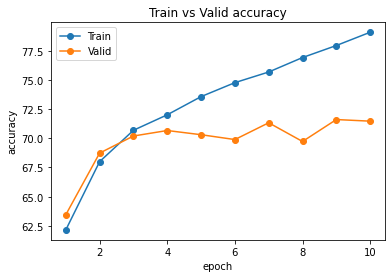

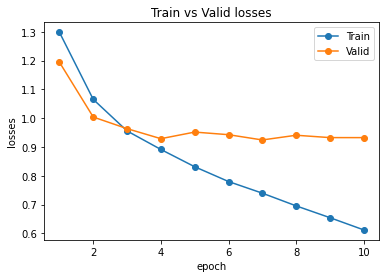

Test accuracy:  72.685 %

Accuracy for class Alnus Glutin is: 15.00 %
Accuracy for class Ambrosia Artemisifolia is: 41.55 %
Accuracy for class Artemisia Vulgaris is: 60.40 %
Accuracy for class Betula Pendula is: 34.56 %
Accuracy for class Cedrus is: 93.04 %
Accuracy for class Corylus Avelana is: 15.17 %
Accuracy for class Quercus is: 78.62 %
Accuracy for class Urtica Diocia is: 41.99 %


In [25]:
(trainloader, testloader, validloader) = createDataLoaders(
    train_data, test_data, valid_data, batch_size=1
)

class_weights = getClassWeights(train_data, no_of_classes)

no_of_epochs = 10
lr = 1e-4
reg = 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs, print_all=True, save_path='./Odin_batch_1')
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

# 5. Search for hyperparameters

In [ ]:
# now let's find the optimal hyperparameters
crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
max_count = 10
no_of_epochs = 10

print('#' * 110)
for count in range(max_count):
    print('%3d / %d' % (count+1, max_count), end='')
    
    model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
    classifier = PollenClassifier(model, force_cpu=FORCE_CPU)
    
    lr = 10**uniform(-4, -3)
    reg = 10**uniform(-4, -3)
    
    print('  |  lr: ' + '{:e}'.format(lr), end='')
    print('  |  reg: ' + '{:e}'.format(reg))
    
    adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    classifier.train(trainloader, validloader, crossEntropy, adam, epochs=no_of_epochs)
    
    classifier.display_acc()
    classifier.display_loss()
    
    print('Test accuracy:  %.3f %%' % classifier.test(testloader))
    print()
    classifier.testPerClass(testloader, classes)
    
    print('#' * 110)
#end for count

# 6. Try to use binary classification

Binary classification worked successfully only for Quercus, Cedrus and Artemisia.

## 6.1. Quercus

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 15:01:40
Epoch   1 started   DONE
current_time: 118.63 sec | train_loss: 0.486 | train_acc: 91.234 % | valid_loss: 0.315 | valid_acc: 92.093 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 237.94 sec | train_loss: 0.279 | train_acc: 93.100 % | valid_loss: 0.297 | valid_acc: 94.083 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 357.35 sec | train_loss: 0.212 | train_acc: 94.379 % | valid_loss: 0.185 | valid_acc: 95.217 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 476.95 sec | train_loss: 0.168 | train_acc: 95.552 % | valid_loss: 0.232 | valid_acc: 94.968 %
-----------------------

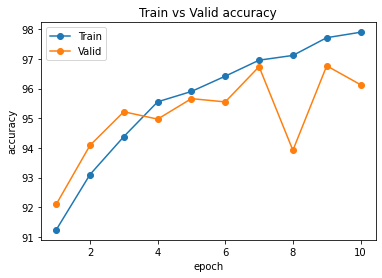

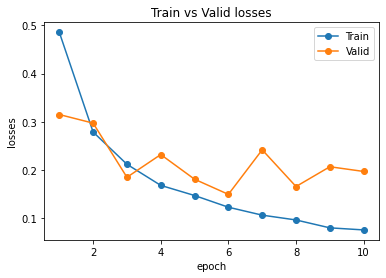

Test accuracy:  96.710 %

Accuracy for class Quercus is: 77.97 %
Accuracy for class Other is: 98.32 %


In [29]:
classes = ('Quercus', 'Other')
no_of_classes = len(classes)

dataset = PollenDataset(data_file='./data.csv', labels_file='./labels.csv', main_class=6)

(train_data, test_data, valid_data) = splitData(
    dataset, test_percent=0.15, valid_percent=0.15
)

(trainloader, testloader, validloader) = createDataLoaders(
    train_data, test_data, valid_data, batch_size=4
)
class_weights = getClassWeights(train_data, no_of_classes)

no_of_epochs = 10
lr, reg = 1e-4, 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(
    trainloader, validloader, crossEntropy, adam, 
    epochs=no_of_epochs, print_all=True, save_path='./binary_quercus'
)
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

In [31]:
# Let's try to find the best classifier, based on "TP" and "TN" values
for i in range(1, no_of_epochs+1):
    classifier.load('./binary_quercus/Epoch_' + str(i) + '.pth')
    print('Epoch: %2d' % i)
    print('Test accuracy:  %.3f %%' % classifier.test(testloader))
    classifier.testPerClass(testloader, classes)
    print('-' * 110)
#end for i

Epoch:  1
Test accuracy:  92.508 %
Accuracy for class Quercus is: 68.88 %
Accuracy for class Other is: 94.54 %
--------------------------------------------------------------------------------------------------------------
Epoch:  2
Test accuracy:  94.415 %
Accuracy for class Quercus is: 66.78 %
Accuracy for class Other is: 96.79 %
--------------------------------------------------------------------------------------------------------------
Epoch:  3
Test accuracy:  95.494 %
Accuracy for class Quercus is: 76.92 %
Accuracy for class Other is: 97.09 %
--------------------------------------------------------------------------------------------------------------
Epoch:  4
Test accuracy:  95.217 %
Accuracy for class Quercus is: 72.38 %
Accuracy for class Other is: 97.18 %
--------------------------------------------------------------------------------------------------------------
Epoch:  5
Test accuracy:  95.936 %
Accuracy for class Quercus is: 83.22 %
Accuracy for class Other is: 97.03 %
-

<b>Best:</b> Epoch 8

## 6.2. Cedrus

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 15:26:48
Epoch   1 started   DONE
current_time: 117.01 sec | train_loss: 0.596 | train_acc: 66.783 % | valid_loss: 0.502 | valid_acc: 74.371 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 234.18 sec | train_loss: 0.486 | train_acc: 75.194 % | valid_loss: 0.476 | valid_acc: 75.781 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 351.34 sec | train_loss: 0.443 | train_acc: 78.594 % | valid_loss: 0.423 | valid_acc: 80.288 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 468.54 sec | train_loss: 0.410 | train_acc: 80.874 % | valid_loss: 0.470 | valid_acc: 79.182 %
-----------------------

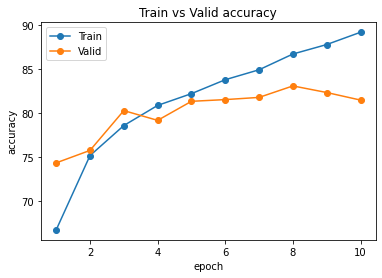

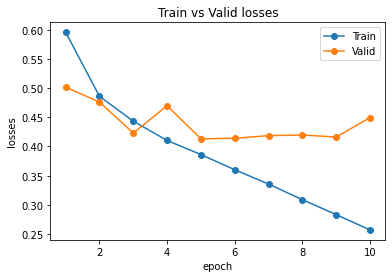

Test accuracy:  80.453 %

Accuracy for class Cedrus is: 78.93 %
Accuracy for class Other is: 82.43 %


In [32]:
classes = ('Cedrus', 'Other')
no_of_classes = len(classes)

dataset = PollenDataset(data_file='./data.csv', labels_file='./labels.csv', main_class=4)

(train_data, test_data, valid_data) = splitData(
    dataset, test_percent=0.15, valid_percent=0.15
)

(trainloader, testloader, validloader) = createDataLoaders(
    train_data, test_data, valid_data, batch_size=4
)
class_weights = getClassWeights(train_data, no_of_classes)

no_of_epochs = 10
lr, reg = 1e-4, 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(
    trainloader, validloader, crossEntropy, adam, 
    epochs=no_of_epochs, print_all=True, save_path='./binary_cedrus'
)
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

In [33]:
# Let's try to find the best classifier, based on "TP" and "TN" values
for i in range(1, no_of_epochs+1):
    print('Epoch: %2d' % i)
    classifier.load('./binary_cedrus/Epoch_' + str(i) + '.pth')
    print('Test accuracy:  %.3f %%' % classifier.test(testloader))
    classifier.testPerClass(testloader, classes)
    print('-' * 110)
#end for i

Epoch:  1
Test accuracy:  75.283 %
Accuracy for class Cedrus is: 77.42 %
Accuracy for class Other is: 72.50 %
--------------------------------------------------------------------------------------------------------------
Epoch:  2
Test accuracy:  75.394 %
Accuracy for class Cedrus is: 64.52 %
Accuracy for class Other is: 89.56 %
--------------------------------------------------------------------------------------------------------------
Epoch:  3
Test accuracy:  79.624 %
Accuracy for class Cedrus is: 80.45 %
Accuracy for class Other is: 78.55 %
--------------------------------------------------------------------------------------------------------------
Epoch:  4
Test accuracy:  78.960 %
Accuracy for class Cedrus is: 90.57 %
Accuracy for class Other is: 63.84 %
--------------------------------------------------------------------------------------------------------------
Epoch:  5
Test accuracy:  81.255 %
Accuracy for class Cedrus is: 81.92 %
Accuracy for class Other is: 80.39 %
------

<b>Best:</b> Epoch 5

## 6.3. Artemisia Vulgaris

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 16:12:36
Epoch   1 started   DONE
current_time: 64.10 sec | train_loss: 0.576 | train_acc: 75.899 % | valid_loss: 0.464 | valid_acc: 91.208 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 128.96 sec | train_loss: 0.484 | train_acc: 86.744 % | valid_loss: 0.528 | valid_acc: 88.001 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 195.31 sec | train_loss: 0.461 | train_acc: 87.864 % | valid_loss: 0.397 | valid_acc: 85.789 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 260.73 sec | train_loss: 0.428 | train_acc: 86.768 % | valid_loss: 0.383 | valid_acc: 80.785 %
------------------------

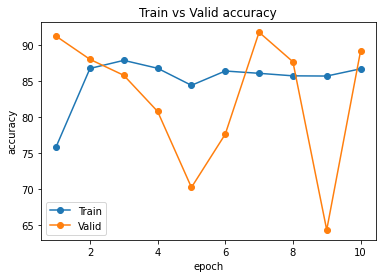

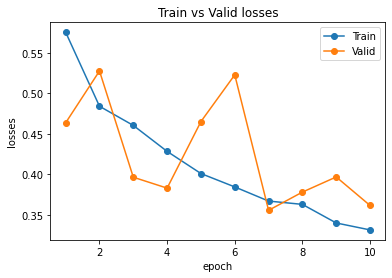

Test accuracy:  88.195 %

Accuracy for class Artemisia Vulgaris is: 76.61 %
Accuracy for class Other is: 89.40 %


In [38]:
classes = ('Artemisia Vulgaris', 'Other')
no_of_classes = len(classes)

dataset = PollenDataset(data_file='./data.csv', labels_file='./labels.csv', main_class=2)

(train_data, test_data, valid_data) = splitData(
    dataset, test_percent=0.15, valid_percent=0.15
)

(trainloader, testloader, validloader) = createDataLoaders(
    train_data, test_data, valid_data, batch_size=8
)
class_weights = getClassWeights(train_data, no_of_classes, power=2)

no_of_epochs = 10
lr, reg = 1e-4, 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(
    trainloader, validloader, crossEntropy, adam, 
    epochs=no_of_epochs, print_all=True, save_path='./binary_artemisia_2'
)
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

In [39]:
# Let's try to find the best classifier, based on "TP" and "TN" values
for i in range(1, no_of_epochs+1):
    print('Epoch: %2d' % i)
    classifier.load('./binary_artemisia_2/Epoch_' + str(i) + '.pth')
    print('Test accuracy:  %.3f %%' % classifier.test(testloader))
    classifier.testPerClass(testloader, classes)
    print('-' * 110)
#end for i

Epoch:  1
Test accuracy:  90.655 %
Accuracy for class Artemisia Vulgaris is: 57.02 %
Accuracy for class Other is: 94.17 %
--------------------------------------------------------------------------------------------------------------
Epoch:  2
Test accuracy:  87.503 %
Accuracy for class Artemisia Vulgaris is: 55.56 %
Accuracy for class Other is: 90.84 %
--------------------------------------------------------------------------------------------------------------
Epoch:  3
Test accuracy:  84.766 %
Accuracy for class Artemisia Vulgaris is: 69.01 %
Accuracy for class Other is: 86.41 %
--------------------------------------------------------------------------------------------------------------
Epoch:  4
Test accuracy:  81.476 %
Accuracy for class Artemisia Vulgaris is: 78.36 %
Accuracy for class Other is: 81.80 %
--------------------------------------------------------------------------------------------------------------
Epoch:  5
Test accuracy:  68.952 %
Accuracy for class Artemisia Vulg

<b>Best:</b> Epoch 4

# 7. Try classfying the rest

The new dataset is the same one as before, except we took out the three pollen types we were able to classify properly.

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 17:56:59
Epoch   1 started   DONE
current_time: 16.79 sec | train_loss: 1.439 | train_acc: 26.692 % | valid_loss: 1.383 | valid_acc: 32.590 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 34.02 sec | train_loss: 1.349 | train_acc: 31.804 % | valid_loss: 1.272 | valid_acc: 34.501 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 51.39 sec | train_loss: 1.270 | train_acc: 34.848 % | valid_loss: 1.269 | valid_acc: 36.306 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 68.75 sec | train_loss: 1.219 | train_acc: 37.369 % | valid_loss: 1.248 | valid_acc: 38.641 %
---------------------------

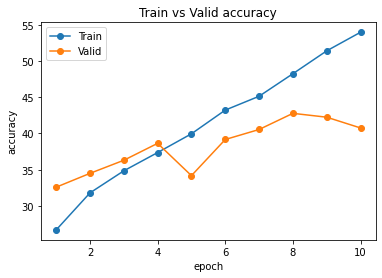

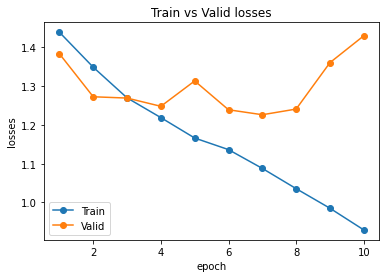

Test accuracy:  41.507 %

Accuracy for class Alnus Glutin is: 55.65 %
Accuracy for class Ambrosia Artemisifolia is: 73.47 %
Accuracy for class Betula Pendula is: 17.48 %
Accuracy for class Corylus Avelana is: 37.62 %
Accuracy for class Urtica Diocia is: 38.78 %


In [51]:
classes = (
    'Alnus Glutin',
    'Ambrosia Artemisifolia',
    'Betula Pendula',
    'Corylus Avelana',
    'Urtica Diocia'
)
no_of_classes = len(classes)

dataset = PollenDataset(data_file='./data_2.csv', labels_file='./labels_2.csv')

(train_data, test_data, valid_data) = splitData(
    dataset, test_percent=0.15, valid_percent=0.15
)

(trainloader, testloader, validloader) = createDataLoaders(
    train_data, test_data, valid_data, batch_size=8
)
class_weights = getClassWeights(train_data, no_of_classes, power=2)

no_of_epochs = 10
lr, reg = 1e-4, 1e-4

model = CNN_Odin(no_of_classes=no_of_classes, picture_size=PICTURE_SIZE)
classifier = PollenClassifier(model, force_cpu=FORCE_CPU)

crossEntropy = nn.CrossEntropyLoss(weight=class_weights)
adam = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

classifier.train(
    trainloader, validloader, crossEntropy, adam, 
    epochs=no_of_epochs, print_all=True, save_path='./five_classes'
)
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

## Let's keep going

Model=CNN_Odin, opt=Adam, lr=0.000100, reg=0.000100, epochs=10, device=cuda:0

Training started at 18:01:39
Epoch   1 started   DONE
current_time: 16.79 sec | train_loss: 0.871 | train_acc: 57.610 % | valid_loss: 1.616 | valid_acc: 43.524 %
--------------------------------------------------------------------------------------------------------------
Epoch   2 started   DONE
current_time: 34.04 sec | train_loss: 0.777 | train_acc: 61.745 % | valid_loss: 1.739 | valid_acc: 40.340 %
--------------------------------------------------------------------------------------------------------------
Epoch   3 started   DONE
current_time: 51.45 sec | train_loss: 0.721 | train_acc: 64.811 % | valid_loss: 1.850 | valid_acc: 42.781 %
--------------------------------------------------------------------------------------------------------------
Epoch   4 started   DONE
current_time: 68.96 sec | train_loss: 0.618 | train_acc: 70.286 % | valid_loss: 2.028 | valid_acc: 46.391 %
---------------------------

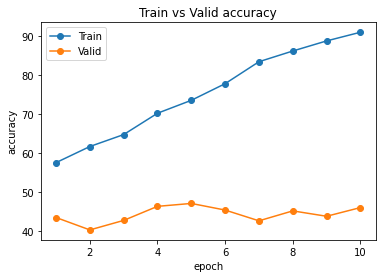

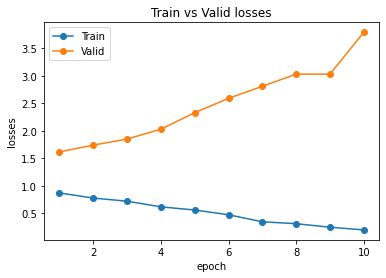

Test accuracy:  46.178 %

Accuracy for class Alnus Glutin is: 33.06 %
Accuracy for class Ambrosia Artemisifolia is: 46.94 %
Accuracy for class Betula Pendula is: 46.12 %
Accuracy for class Corylus Avelana is: 43.07 %
Accuracy for class Urtica Diocia is: 54.37 %


In [54]:
classifier.train(
    trainloader, validloader, crossEntropy, adam, 
    epochs=no_of_epochs, print_all=True, save_path='./five_classes_2'
)
classifier.display_acc()
classifier.display_loss()

print('Test accuracy:  %.3f %%' % classifier.test(testloader))
print()
classifier.testPerClass(testloader, classes)

<b>Conclusion: </b>While Quercus, Cedrus and Artemisia Vulgaris can be classified properly due to their features, the other classes either lack representants or they simply cannot be classified properly.